In [3]:
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from src.s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
import sys
import time
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-200osoot because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
import torch
import torch.nn as nn 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
from pathlib import Path
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTMClassifier(nn.Module):
    def __init__(self, feature_size, n_state, hidden_size, rnn="GRU", regres=True, bidirectional=False, return_all=False,
                 seed=random.seed('2021')):
        
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_state = n_state
        self.seed = seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.rnn_type = rnn
        self.regres = regres
        self.return_all = return_all
        
        # Input to torch LSTM should be of size (seq_len, batch, input_size)
        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)
        else:
            self.rnn = nn.LSTM(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)

        self.regressor = nn.Sequential(nn.BatchNorm1d(num_features=self.hidden_size),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Linear(self.hidden_size, self.n_state),
                                       nn.Sigmoid())

    def forward(self, input, past_state=None, **kwargs):
        input = input.to(self.device)
        self.rnn.to(self.device)
        self.regressor.to(self.device)
        if not past_state:
            #  hidden states: (num_layers * num_directions, batch, hidden_size)
            past_state = torch.zeros([1, input.shape[0], self.hidden_size]).to(self.device)
        if self.rnn_type == 'GRU':
            all_encodings, encoding = self.rnn(input, past_state)
        else:
            all_encodings, (encoding, state) = self.rnn(input, (past_state, past_state))
        
        if self.regres:
            if not self.return_all:
                return self.regressor(encoding.view(encoding.shape[1], -1))
            else:
                reshaped_encodings = all_encodings.view(all_encodings.shape[1]*all_encodings.shape[0],-1)
                return torch.t(self.regressor(reshaped_encodings).view(all_encodings.shape[0],-1))
        else:
            return encoding.view(encoding.shape[1], -1)

In [1]:
import copy

def train_model(model, train_dataloader, n_epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    criterion = nn.BCELoss().to(device)

    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    iters,iters_sub, train_acc, val_acc = [], [] ,[], []
    
    best_loss = 10000.0
    
    n=0
    for epoch in tqdm(range(1, n_epochs + 1)):
        t0 = time.time()
        # print("")
        # print('======== Epoch {:} / {:} ========'.format(epoch, n_epochs))
        # print('Training...')

        total_train_loss = 0
        train_losses=[]
        model = model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = (time.time() - t0)
                # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            b_input= batch[0].to(device)
            target =  batch[1].to(device)
            iters.append(n)
            optimizer.zero_grad()
            out = model(b_input)
            out = torch.transpose(out,1,0)[0]

            # target = torch.argmax(b_target, 1)
            loss = criterion(out, target)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            train_losses.append(loss.item())
            
            if n % 10 == 0:
                iters_sub.append(n)
                
                #train_acc.append(get_accuracy(model, train_dataloader))
                #print(get_accuracy(model, train_dataloader))
                #val_acc.append(get_accuracy(model, validation_dataloader))
            # increment the iteration number
            n += 1

        training_time = (time.time() - t0)
        avg_train_loss = total_train_loss / len(train_dataloader)
        # print("")
        # print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # print("  Training epoch took: {:}".format(training_time))


        # print("")
        # print("Running Validation...")

        t0 = time.time()
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        val_losses = []
        model = model.eval()

        train_loss = np.mean(train_losses)
    
        history['train'].append(train_loss)
        
        # print(f'Epoch {epoch}: train loss {train_loss} ')
    plt.style.use('seaborn-white')
    plt.plot(history['train'])

    plt.title('LSTM  Training Curves')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch Number')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
    return model.eval(), history

def evaluate_model(model, x_test, y_test):
    #INFERENCE ON TEST SET
    x_test.to(device)
    y_test.to(device)
    predictions = model(x_test).detach().numpy()
    
    y_test = y_test.numpy()
    y_pred = predictions.round()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f'accuracy: {accuracy}')
    print(f'f1: {f1}')
    print(f'precision: {precision}')
    return y_pred, predictions

In [142]:
import pickle
with open('data/5min/train.pickle', 'rb') as handle:
    train = pickle.load(handle)
with open('data/5min/test.pickle', 'rb') as handle:
    test = pickle.load(handle)

In [143]:
from sklearn.preprocessing import StandardScaler
X_train = train['X']
X_train_scaled = np.zeros_like(X_train)
y_train = np.array(train['y'])
X_test = test['X']
X_test_scaled = np.zeros_like(X_test)
y_test = np.array(test['y'])

for i in range(X_train.shape[1]):
    scaler = StandardScaler().fit(X_train[:,i,:])
    X_train_scaled[:,i,:] = scaler.transform(X_train[:,i,:])
    X_test_scaled[:,i,:] = scaler.transform(X_test[:,i,:])

In [144]:
X_train.shape #(sample size, #feature, #time steps)

(417, 5, 150)

In [180]:
from torch.utils.data import TensorDataset

#Flipping so it goes batchsize, seq len, num features
X_train_scaled = torch.flip(torch.tensor(X_train, dtype=torch.float), [1,2])
y_train = torch.tensor(y_train, dtype=torch.float)

X_test_scaled = torch.flip(torch.tensor(X_test, dtype=torch.float), [1,2])
y_test = torch.tensor(y_test, dtype=torch.float)

train_dataset= TensorDataset(X_train_scaled, y_train)

test_dataset= TensorDataset(X_test_scaled, y_test)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 256

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset)
        )

In [181]:
X_train_scaled.shape

torch.Size([417, 5, 150])

In [182]:
model = LSTMClassifier(X_train.shape[2], #num features 
                1, #num classes,
                20, #hidden size
                rnn="lstm" #rnn type
           )
model.to(device)

LSTMClassifier(
  (rnn): LSTM(150, 20, batch_first=True)
  (regressor): Sequential(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

100%|██████████| 2000/2000 [00:24<00:00, 82.44it/s]


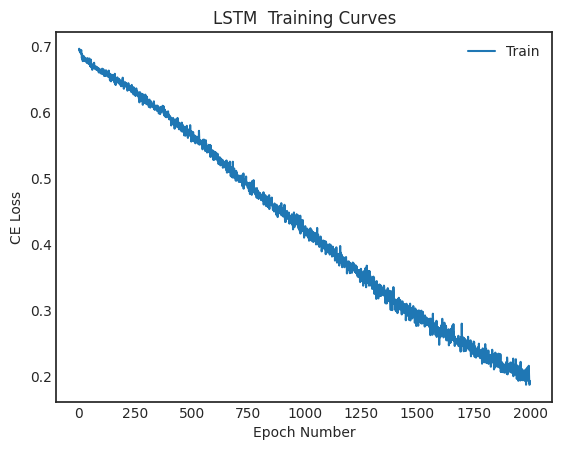

In [183]:
model, history = train_model(model, train_dataloader, 2000, 1e-3)

In [184]:
y_pred, output = evaluate_model(model, X_test_scaled, y_test)

accuracy: 0.9009009009009009
f1: 0.9133858267716535
precision: 0.8405797101449275


In [185]:
output.shape

(111, 1)

In [186]:
y_score = []
for i in output:
    if i[0] < 0.5:
        y_score.append(1 - i[0])
    else:
        y_score.append(i[0])

In [187]:
roc_auc_score(y_test, y_score)

0.6961613532856213

In [188]:
results = pd.DataFrame({
    'user_id': test['uid'],
    'ground_truth': y_test.tolist(),
    'prediction': y_pred.T[0].tolist(),
    'correctness': (y_test.numpy() == y_pred.T[0]).tolist(),
    'confidence': y_score,
    'x_number_of_days_before_delivery': test['start_date']
})

In [189]:
results

,user_id,ground_truth,prediction,correctness,confidence,x_number_of_days_before_delivery
0,1024,0.0,0.0,True,0.853866,57
1,1032,0.0,0.0,True,0.921968,18
2,2056,0.0,0.0,True,0.962059,47
3,2058,0.0,0.0,True,0.797487,123
4,1035,0.0,0.0,True,0.691885,172
...,...,...,...,...,...,...
106,1393,0.0,0.0,True,0.634688,47
107,1387,0.0,0.0,True,0.871471,96
108,405,0.0,1.0,False,0.800914,37
109,595,0.0,0.0,True,0.618108,119


In [190]:
results.to_excel("results/5min/largest_window.xlsx")  